# 🤒 Epidemic mitigation project

### Importing the relevant packages

In [1]:
import matplotlib.pyplot as plt
from gym import spaces

"""Environment imports"""
from epidemic_env.env       import Env, Log
from epidemic_env.dynamics  import ModelDynamics, Observation
from epidemic_env.visualize import Visualize
from epidemic_env.agent     import Agent

"""Pytorch and numpy imports"""
import numpy as np
import torch
from torch import nn

%matplotlib inline

### Loading the environment

['Lausanne', 'Geneva', 'Sion', 'Neuchâtel', 'Basel', 'Bern', 'Lücern', 'St-Gallen', 'Zürich']


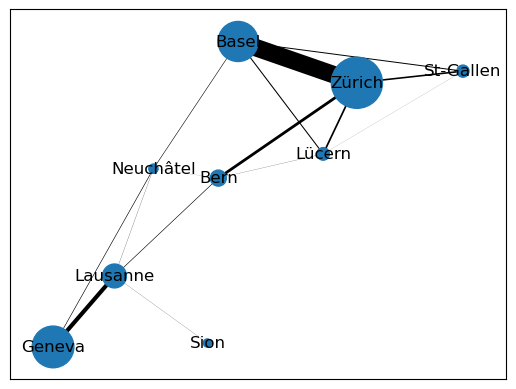

In [2]:
dyn = ModelDynamics('config/switzerland.yaml')   # load the switzerland map
print(dyn.cities) # we added the encoding to ModelDynamics
dyn.draw_map()

sampled action : 2
Sampled observation


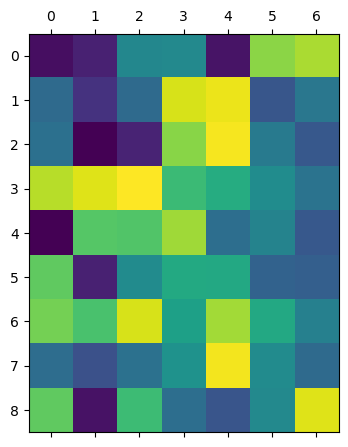

In [3]:
action_space        =   spaces.Discrete(5)
observation_space   =   spaces.Box( low=0,
                                    high=1,
                                    shape=(2, dyn.n_cities, dyn.env_step_length),
                                    dtype=np.float16)
print(f"sampled action : {action_space.sample()}")
print("Sampled observation")
plt.matshow(observation_space.sample()[0,:,:])
plt.show()

In [4]:
SCALE = 100
ACTION_NULL = 0
ACTION_CONFINE = 1
ACTION_ISOLATE = 2
ACTION_HOSPITAL = 3
ACTION_VACCINATE = 4


def action_preprocessor(a:torch.Tensor, dyn:ModelDynamics):
    action = { # DO NOTHING
        'confinement': False, 
        'isolation': False, 
        'hospital': False, 
        'vaccinate': False,
    }
    
    if a == ACTION_CONFINE:
        action['confinement'] = True
    elif a == ACTION_ISOLATE:
        action['isolation'] = True
    elif a == ACTION_VACCINATE:
        action['vaccinate'] = True
    elif a == ACTION_HOSPITAL:
        action['hospital'] = True
        
    return action
    
def observation_preprocessor(obs: Observation, dyn:ModelDynamics):
    infected = SCALE * np.array([np.array(obs.city[c].infected)/obs.pop[c] for c in dyn.cities])
    dead = SCALE * np.array([np.array(obs.city[c].dead)/obs.pop[c] for c in dyn.cities])
    confined = np.ones_like(dead)*int((dyn.get_action()['confinement']))
    return torch.Tensor(np.stack((infected, dead, confined))).unsqueeze(0)

env = Env(  dyn,
            action_space=action_space,
            observation_space=observation_space,
            action_preprocessor=action_preprocessor,
            observation_preprocessor=observation_preprocessor,
            )

### Question 1.a) study the behavior of the model when epidemics are unmitigated.

Running the epidemic simulation for one episode (30 weeks), without epidemic mitigation (meaning no action is
taken, i.e. all values in the action dictionary are set to False).

In [5]:
""" Run the simulation """
log = []
finished = False
obs, info = env.reset(2)
while not finished:
    action = 0
    obs, R, finished, info = env.step(action)
    log.append(info) # save the information dict for logging
    if finished:
        break
    
""" Parse the logs """
total = {p:np.array([getattr(l.total,p) for l in log]) for p in dyn.parameters}
cities = {c:{p:np.array([getattr(l.city[c],p) for l in log]) for p in dyn.parameters} for c in dyn.cities}
actions = {a:np.array([l.action[a] for l in log]) for a in log[0].action.keys()}

#### Plots

C:\Users\Daria\AppData\Local\Temp\ipykernel_17216\1897533904.py:7: RuntimeWarning: divide by zero encountered in log
  [ax_leftstate.plot(np.log(y)) for y in total.values()] # log-lin


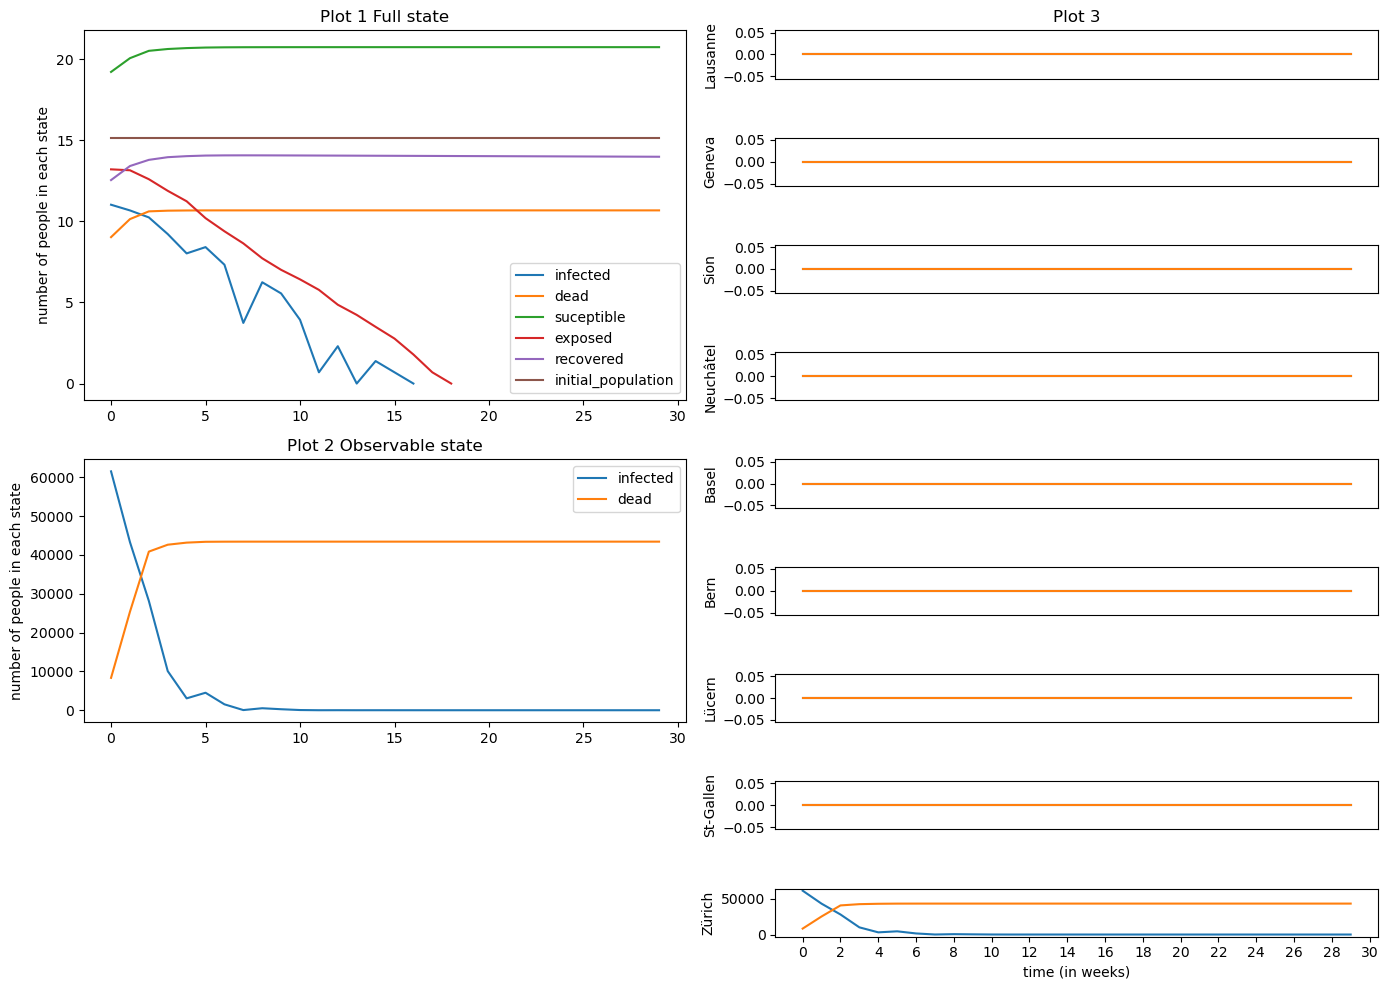

In [6]:
from matplotlib.ticker import MultipleLocator

def plot_all(leftstate = True, leftobs =True, leftactions = True, right_per_city = True, order = [1, 2, 3, 4]):
    fig = plt.figure(figsize=(14,10))
    if leftstate: 
        ax_leftstate = plt.subplot2grid(shape=(9, 2), loc=(0, 0), rowspan=4)
        [ax_leftstate.plot(np.log(y)) for y in total.values()] # log-lin
        ax_leftstate.legend(total.keys())
        ax_leftstate.set_title(f'Plot {order[0]} Full state')
        ax_leftstate.set_ylabel('number of people in each state')
        
    if leftobs:
        ax_leftobs = plt.subplot2grid(shape=(9, 2), loc=(4, 0), rowspan=3)
        [ax_leftobs.plot(total[y]) for y in ['infected','dead']]
        ax_leftobs.legend(['infected','dead'])
        ax_leftobs.set_title(f'Plot {order[1]} Observable state')
        ax_leftobs.set_ylabel('number of people in each state')
    
    if leftactions:
        ax_leftactions = plt.subplot2grid(shape=(9, 2), loc=(7, 0), rowspan=2)
        ax_leftactions.imshow(np.array([v for v in actions.values()]).astype(np.uint8),aspect='auto')
        ax_leftactions.set_title(f'Plot {order[2]} Actions')
        ax_leftactions.set_yticks([0,1,2,3])
        ax_leftactions.set_yticklabels(list(actions.keys()))
        ax_leftactions.set_xlabel('time (in weeks)')
                
    if right_per_city:
        ax_right = [plt.subplot2grid(shape=(9, 2), loc=(0, 1), colspan=1)]
        ax_right += [plt.subplot2grid(shape=(9, 2), loc=(i, 1), colspan=1) for i in range(1,9)]
        ax_right = {k:ax_right[_id] for _id,k in enumerate(cities.keys())}
        [ax.plot(cities[c]['infected']) for c, ax in ax_right.items()]
        [ax.plot(cities[c]['dead']) for c, ax in ax_right.items()]
        [ax.set_ylabel(c) for c, ax in ax_right.items()]
        [ax.xaxis.set_major_locator(plt.NullLocator()) for c, ax in ax_right.items()]
        ax_right['Zürich'].set_xlabel('time (in weeks)')
        ax_right['Lausanne'].set_title(f'Plot {order[3]}')
        ax_right['Zürich'].xaxis.set_major_locator(MultipleLocator(2.000))

    fig.tight_layout()
    plt.show()
    
plot_all(leftstate = True, leftobs =True, leftactions = False, right_per_city = True, order = [1, 2, 0, 3])

### Question 2.a) Implement Pr. Russo’s Policy

In [7]:
class RussoAgent(Agent):
    def __init__(self,  env:Env,
                # Additionnal parameters to be added here
                ):
        """
        Example agent implementation. Just picks a random action at each time step.
        """
        self.env = env
        self.count_confinement = 0
        self.dict = np.array([295000, 900000, 34978, 44531, 830000, 133115, 82000, 76213, 1354000])
        
    def load_model(self, savepath):
        # This is where one would define the routine for loading a pre-trained model
        pass

    def save_model(self, savepath):
        # This is where one would define the routine for saving the weights for a trained model
        pass

    def optimize_model(self):
        # This is where one would define the optimization step of an RL algorithm
        return 0
    
    def reset(self,):
        # This should be called when the environment is reset
        pass
    
    def act(self, obs):
        # this takes an observation and returns an action
        total = np.sum(np.array(obs[0, 0, :, -1])*self.dict)/SCALE
        if total >= 20000:
            self.count_confinement = 1
            return 1
        if self.count_confinement == 4:
            self.count_confinement = 0
        if self.count_confinement != 0:
            self.count_confinement += 1
            return 1
        return 0

In [8]:
agent = RussoAgent(env)
log = []
finished = False
obs, info = env.reset(2)
agent.reset()
agent.epsilon = 0
while not finished:
    action = agent.act(obs)
    obs, R, finished, info = env.step(action)
    log.append(info) # save the information dict for logging
    if finished:
        break

""" Parse the logs """
total = {p:np.array([getattr(l.total,p) for l in log]) for p in dyn.parameters}
cities = {c:{p:np.array([getattr(l.city[c],p) for l in log]) for p in dyn.parameters} for c in dyn.cities}
actions = {a:np.array([l.action[a] for l in log]) for a in log[0].action.keys()}

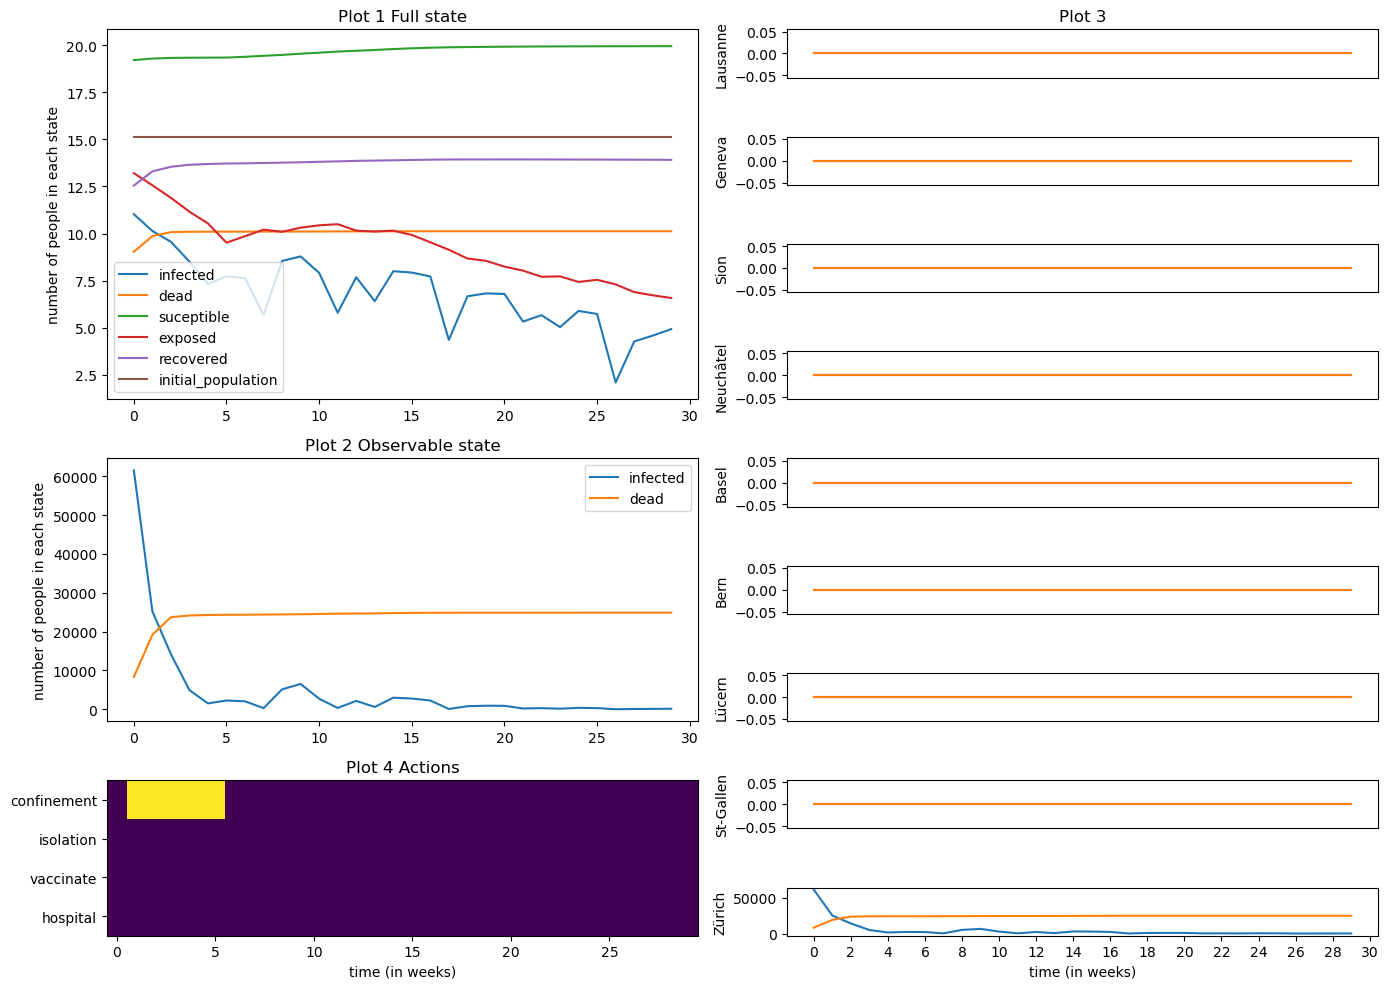

In [9]:
plot_all(leftstate = True, leftobs =True, leftactions = True, right_per_city = True, order = [1, 2, 4, 3])

### Question 2.b) Evaluate Pr. Russo’s Policy

In [10]:
# agent = RussoAgent(env)

# def hist_avg(ax, data,title):
#     ymax = 50
#     if title == 'deaths':
#         x_range = (1000,200000)
#     elif title == 'cumulative rewards':
#         x_range = (-300,300)
#     elif 'days' in title:
#         x_range = (0,200)
#     else:
#         raise ValueError(f'{title} is not a valid title')
#     ax.set_title(title)
#     ax.set_ylim(0,ymax)
#     ax.vlines([np.mean(data)],0,ymax,color='red')
#     ax.hist(data,bins=60,range=x_range)
    
# def run_experiment(agent, num_episodes):
#     fig, ax = plt.subplots(3, 1, figsize=(10,10))
#     rewards = []
#     confine = []
#     death = []
#     for trace in range(num_episodes):
#         log = []
#         seed = trace
#         finished = False
#         obs, info = env.reset(seed)
#         agent.reset()
#         n_weeks_confined = 0
#         R_sum = 0
#         while not finished:
#             action = agent.act(obs)
#             obs, R, finished, info = env.step(action)
#             log.append(info) # save the information dict for logging
#             R_sum += R[0][0]
#             if action == 1:
#                 n_weeks_confined += 1
#             if finished:
#                 break
#         """ Parse the logs """
#         total = {p:np.array([getattr(l.total,p) for l in log]) for p in dyn.parameters}
#         confine.append(n_weeks_confined) 
#         rewards.append(R_sum)
#         death.append(np.sum(total['dead']))
#     hist_avg(ax[0], confine, "days")
#     hist_avg(ax[1],rewards, "cumulative rewards")
#     hist_avg(ax[2],death, "deaths")
# run_experiment(agent, 50)

### Question 3.a) implementing Deep Q-Learning

In [11]:
from itertools import count
from DQ_learning.model import DQN
from DQ_learning.agent import Agent, ReplayMemory, DQNAgent
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

action_space        =   spaces.Discrete(2)
observation_space   =   spaces.Box( low=0,
                                    high=1,
                                    shape=(2, dyn.n_cities, dyn.env_step_length),
                                    dtype=np.float16)

env = Env(  dyn,
            action_space=action_space,
            observation_space=observation_space,
            action_preprocessor=action_preprocessor, # ????
            observation_preprocessor=observation_preprocessor,
            )

n_episodes = 500
LR = 5 * 10**(-3)
GAMMA = 0.9
buffer_size = 20000
BATCH_SIZE = 2048

In [28]:
if torch.cuda.is_available():
    num_episodes = 600
else:
    num_episodes = 50
    
agent = DQNAgent(env, DQN)
log = []
for i_episode in range(num_episodes):
    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device)
    R_sum = []
    for t in count():
        action = agent.act(state)
        observation, reward, terminated, truncated = env.step(action.item())
        R_sum.append(reward[0][0])
        reward = torch.tensor([reward], device=device)
        done = terminated or truncated

        if terminated:
            break
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device)

        # Store the transition in memory
        agent.memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        agent.optimize_model()

        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = agent.target_net.state_dict()
        policy_net_state_dict = agent.policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*0.005 + target_net_state_dict[key]*(1-0.005)
        agent.target_net.load_state_dict(target_net_state_dict)
    if i_episode%20 == 0:
        print(np.mean(R_sum[-20:]))

C:\Users\Daria\AppData\Local\Temp\ipykernel_17216\4160689634.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = torch.tensor(state, dtype=torch.float32, device=device)
C:\Users\Daria\AppData\Local\Temp\ipykernel_17216\4160689634.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  next_state = torch.tensor(observation, dtype=torch.float32, device=device)


2.8
4.0
3.4
